In [1]:
from math import floor, sqrt
from scipy import ndimage, optimize
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.neighbors import KDTree
from numpy import pi, r_
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math, random, sys, os
sys.path.insert(0, '../../../../FISH-annotation/Annotation/fishannotation/fishannotation')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

### Cluster annotations without cropping

In [49]:
cwd = os.getcwd()
clustering_params = ['AffinityPropagation', -350]
declumping_params = ['KMeans', 2]

img_filename = 'C2-ISP_293T_TFRC_InSituPrep_20180712_1_MMStack_Pos0_700.png'
img_filepath = cwd + '/datasets/images/smfish.png'
json_filepath = cwd + '/datasets/anno/smFISH_cells.json'
ref_filepath = cwd + '/datasets/ref/smFISH_ref.csv'

In [3]:
im = imread(img_filepath)
img_height = len(im)

qa = QuantiusAnnotation(json_filepath, img_filename)
sa = SpotAnnotationAnalysis(qa)
anno_all = qa.df()

# get consensus clusters
clusters = sa.get_clusters(anno_all, clustering_params)
cluster_size_threshold = util.get_cluster_size_threshold(clusters)
small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
clumpiness_threshold = util.get_clumpiness_threshold(large_clusters)
clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
clusters_post_qc = nonclumpy_clusters
if len(clumpy_clusters.index) is not 0:
    for i in range(len(clumpy_clusters.index)):
        subclusters = util.declump(clumpy_clusters, i, declumping_params)
    clusters_post_qc = pd.concat([subclusters, clusters_post_qc], ignore_index=True)

../../../../FISH-annotation/Annotation/util.py:68: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  occasions = np.unique(df.loc[:, ['time_when_completed']].as_matrix())			# get the list of occasions
../../../../FISH-annotation/Annotation/util.py:72: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  one_occasion_array = one_occasion_df.loc[:, ['x', 'y', 'timestamp', 'worker_id']].as_matrix()


### Save consensus centroids from annotations without cropping

In [4]:
clusters_post_qc_list = []
for index in clusters_post_qc.index:
    row = clusters_post_qc.iloc[index]
    x, y = row['centroid_x'], row['centroid_y']
    clusters_post_qc_list.append([x, img_height-y])
np.savetxt(cwd + '/datasets/consensus/coords_no_cropping.csv', np.asarray(clusters_post_qc_list), delimiter=",", comments='', header='centroid_x,centroid_y')

### Show consensus centroids from annotations without cropping

Text(0.5,1,'Consensus Centroids Found without Cropping')

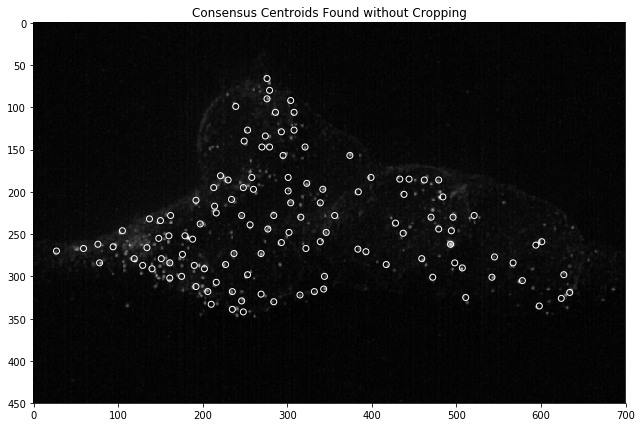

In [64]:
plt.figure(figsize=(12,7))
for x, y in clusters_post_qc_list:
    plt.scatter(x, y, edgecolors='white', facecolors='None')
plt.gca().invert_yaxis()
plt.imshow(im, cmap='gray')
plt.title('Consensus Centroids Found without Cropping')

### Show consensus centroids reassembled from crops

(Each crop is shown in a different color.)

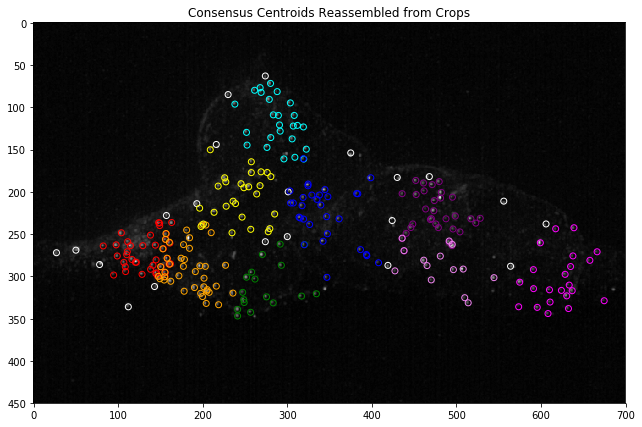

In [35]:
plt.figure(figsize=(12,7))
coords_blacked = np.asarray(pd.read_csv('/Users/jenny.vo-phamhi/Documents/fish_annotation_paper/figures/SI/fig_5c/datasets/consensus/smfish_blacked_coords.csv'))
for coord in coords_blacked:
    plt.scatter(coord[0], 450-coord[1], edgecolors='white', facecolors='None')

colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'violet', 'magenta']    
for i in range(9):
    coords = np.asarray(pd.read_csv(cwd + '/datasets/consensus/smfish_' + str(i) + '_coords.csv'))
    stats = np.asarray(pd.read_csv(cwd + '/datasets/consensus/smfish_' + str(i) + '.csv', header=None))
    xmin = stats[0][0]
    ymin = stats[2][0]
    ymax = stats[3][0]
    height = ymax - ymin
    zoom_factor = stats[4][0]

    refit = []
    for coord in coords:
        x = coord[0]/zoom_factor + xmin
        y = height - coord[1]/zoom_factor + ymin
        refit.append([x, y])
        total.append([x, y])
    refit = np.asarray(refit)

    for coord in refit:
        plt.scatter(coord[0], coord[1], edgecolors=colors[i], facecolors='None')

plt.title('Consensus Centroids Reassembled from Crops')
plt.gca().invert_yaxis()
plt.imshow(im, cmap='gray')
plt.show()

In [45]:
consensus_with_cropping = np.asarray(pd.read_csv(cwd + '/datasets/consensus/coords_with_cropping.csv'))
consensus_no_cropping = np.asarray(pd.read_csv(cwd + '/datasets/consensus/coords_no_cropping.csv'))

In [46]:
correctness_threshold = 4

In [50]:
reference_coords = np.asarray(pd.read_csv(ref_filepath))[:,:2]
reference_kdt = KDTree(reference_coords, leaf_size=2, metric='euclidean')

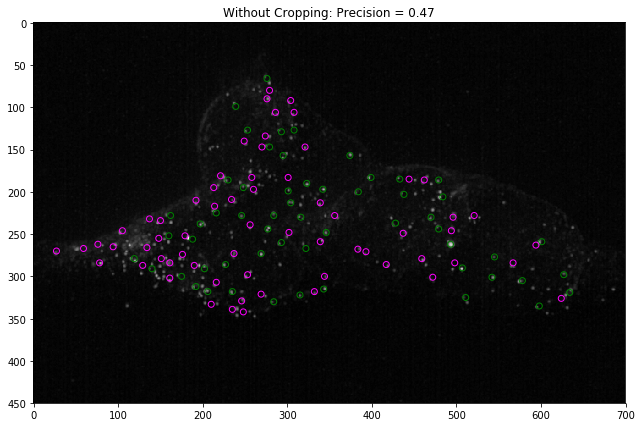

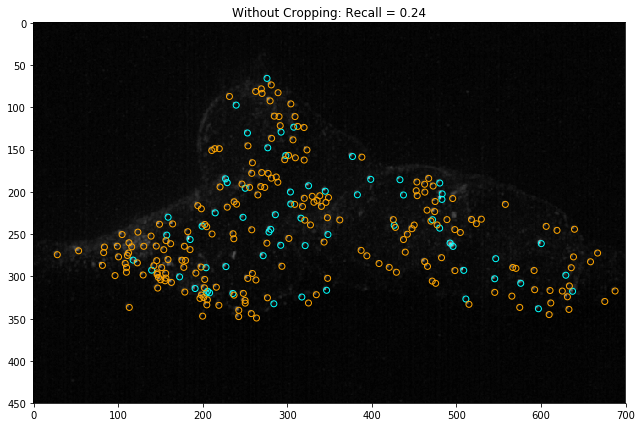

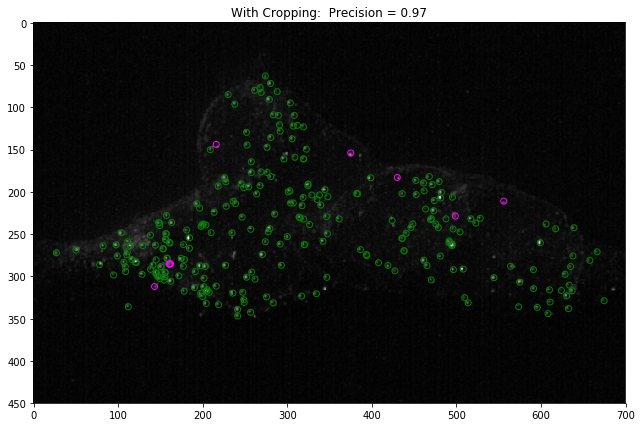

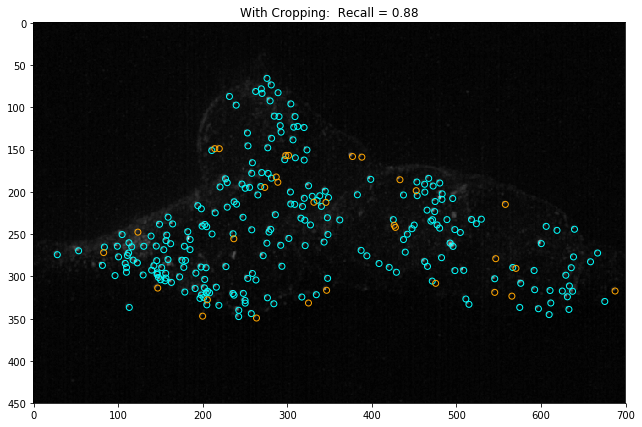

In [65]:
for i in [0,1]:
        
    consensus_coords = consensus_no_cropping if i==0 else consensus_with_cropping
    s = 'Without Cropping:' if i==0 else 'With Cropping: '
    
    consensus_kdt = KDTree(consensus_coords, leaf_size=2, metric='euclidean')

    correct_consensus = []
    incorrect_consensus = []
    detected_reference = []
    undetected_reference = []

    # correct vs. incorrect

    for consensus_coord in consensus_coords:
        dist, ind = reference_kdt.query([consensus_coord], k=1)
        if dist[0][0] < correctness_threshold:
            correct_consensus.append(consensus_coord)
        else:
            incorrect_consensus.append(consensus_coord)

    # detected vs. undetected

    for reference_coord in reference_coords:
        dist, ind = consensus_kdt.query([reference_coord], k=1)
        if dist[0][0] < correctness_threshold:
            detected_reference.append(reference_coord)
        else:
            undetected_reference.append(reference_coord)
    
    precision = len(correct_consensus)/len(consensus_coords)
    recall = len(detected_reference)/len(reference_coords)
    
    # plot Precision
    plt.figure(figsize=(12,7))
    for x, y in correct_consensus:
        plt.scatter(x, y, edgecolors='green', facecolors='None')
    for x, y in incorrect_consensus:
        plt.scatter(x, y, edgecolors='magenta', facecolors='None')
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    plt.title('%s Precision = %s' % (s, round(precision, 2)))
    plt.show()
    
    # plot Recall
    plt.figure(figsize=(12,7))
    for x, y in detected_reference:
        plt.scatter(x, y, edgecolors='cyan', facecolors='None')
    for x, y in undetected_reference:
        plt.scatter(x, y, edgecolors='orange', facecolors='None')
    plt.gca().invert_yaxis()
    plt.imshow(im, cmap='gray')
    plt.title('%s Recall = %s' % (s, round(recall, 2)))
    plt.show()
        